## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

# Global value
NUM_NEURONS = [512, 256, 128]
OUTPUT_UNITS = 10

In [6]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(NUM_NEURONS):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=OUTPUT_UNITS, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
"""
# 載入 Callbacks, 並將監控目標設為 validation loss, 且只存最佳參數時的模型

keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, 
                                save_weights_only=False, mode='auto', period=1)

filepath：string，保存模型文件的路徑。

monitor：要監控的數量。

verbose：詳細模式，0或1。

save_best_only：if save_best_only=True，根據監控數量的最新最佳模型不會被覆蓋。

save_weights_only：如果為True，則僅保存模型的權重（model.save_weights(filepath)），否則保存完整模型（model.save(filepath)）。

mode：{auto，min，max}之一。如果save_best_only=True，則基於監控量的最大化或最小化來做出覆蓋當前保存文件的決定。
                           對於val_acc，這應該是max，對於val_loss這應該是min，等等。在auto模式中，方向是從監控數量的名稱自動推斷出來的。

period：檢查點之間的間隔（時期數）
"""

from keras.callbacks import ModelCheckpoint

model_ckpt_best = ModelCheckpoint(filepath="./tmp.h5", 
                                  monitor="val_loss", 
                                  save_best_only=True)

model_ckpt_false = ModelCheckpoint(filepath="./tmp.h5", 
                                   monitor="val_loss", 
                                   save_best_only=False)

model_ckpt_weight = ModelCheckpoint(filepath="./tmp.h5", 
                                    monitor="val_loss", 
                                    save_best_only=True,
                                    save_weights_only=True)

In [8]:
def Training_Model(model_ckpt, model):
        #model = build_mlp(x_train.shape[1:])
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
  
        model.fit(
                  x_train, y_train,
                  epochs=EPOCHS, 
                  batch_size= BATCH_SIZE,
                  validation_data=(x_test, y_test), 
                  shuffle=True,
                  callbacks=[model_ckpt]
                 )
        
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
    
        # Load back
        # model = keras.models.load_model("./tmp.h5")
        # loss_loadback, acc_loadback = model_fb.evaluate(x_test, y_test)

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

def Draw_Result(model, model_fb):
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    # Load back
    model_fb = keras.models.load_model("./tmp.h5")
    loss_loadback, acc_loadback = model_fb.evaluate(x_test, y_test)
    
    plt.plot(range(len(train_loss)), train_loss, label="train loss")
    plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
    plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
    plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
    plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
    plt.legend()
    plt.title("Accuracy")
    plt.show()

In [14]:
model_best = build_mlp(x_train.shape[1:])
Training_Model(model_ckpt_best, model_best)

W0723 11:32:40.928586 20924 deprecation.py:323] From D:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_12 (Batc (None, 128)               512       
__________

Epoch 50/50
10000/10000 [==============================] - 1s 65us/step


10000/10000 [==============================] - 1s 68us/step


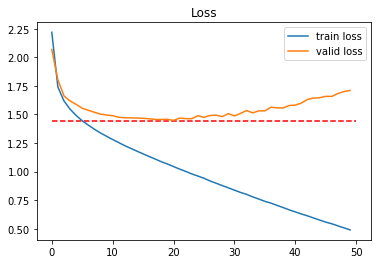

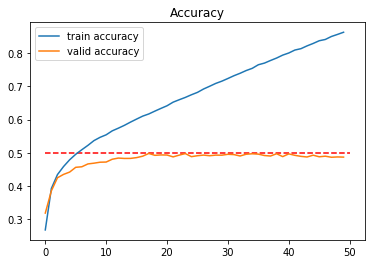

In [20]:
#save_best_only = True
model_best_fb = keras.models.load_model("./tmp.h5")
Draw_Result(model_best, model_best_fb)

In [21]:
model_false = build_mlp(x_train.shape[1:])
Training_Model(model_ckpt_false, model_false)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_15 (Batc (None, 128)               512       
__________

Epoch 50/50
10000/10000 [==============================] - 1s 80us/step


10000/10000 [==============================] - 1s 100us/step


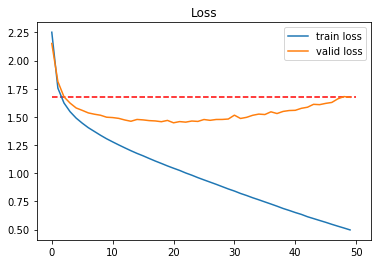

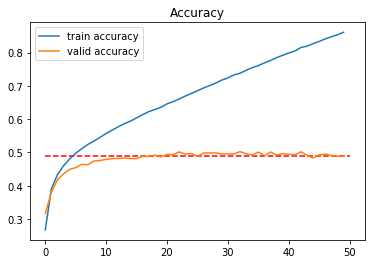

In [25]:
#save_best_only = False
model_false_fb = keras.models.load_model("./tmp.h5")
Draw_Result(model_false, model_false_fb)

In [10]:
model_weight = build_mlp(x_train.shape[1:])
Training_Model(model_ckpt_weight, model_weight)

W0723 14:11:26.031645 16264 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 14:11:26.042615 16264 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 14:11:26.044609 16264 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 14:11:26.094506 16264 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0723 14:11:26.233105 16264 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\ke

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

Epoch 50/50
50000/50000 [==============================] - 3s 69us/step - loss: 0.5161 - acc: 0.8529 - val_loss: 1.6645 - val_acc: 0.4852


#model_weight_fb = build_mlp(x_train.shape[1:])
#model_weight_fb.load_weights("./tmp.h5")
#Draw_Result(model_weight, model_weight_fb)

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
def plot_results(results):
    color_bar = ["r", "g", "b", "y", "m", "k"]

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
        plt.hlines(y=results[cond]['loss_loadback'], xmin=0, xmax=len(results[cond]['train-loss']), colors=color_bar[i], linestyles='--')
    plt.title("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
        plt.hlines(y=results[cond]['acc_loadback'], xmin=0, xmax=len(results[cond]['train-acc']), colors=color_bar[i], linestyles='--')
    plt.title("Accuracy")
    plt.legend()
    plt.show()

Experiment with save_weights_only=True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 1

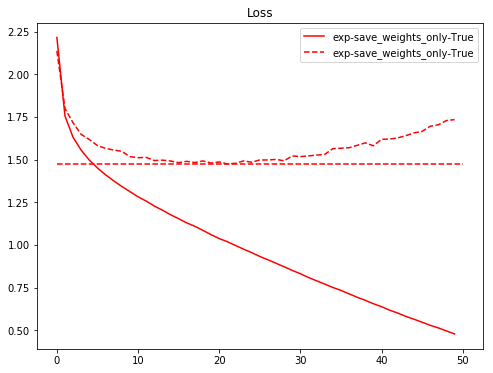

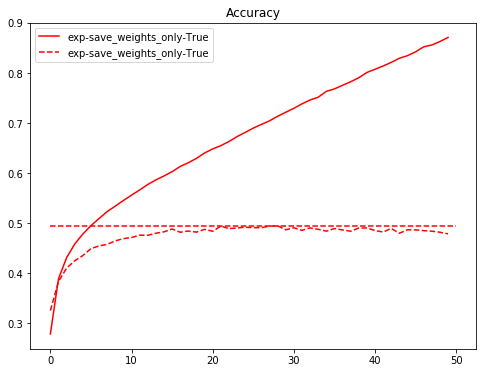

In [24]:
results = {}

for save_weights_only in [True]:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with save_weights_only=%s" % str(save_weights_only))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                                 monitor="val_loss", 
                                 save_best_only=True,
                                 save_weights_only=save_weights_only
                                )
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              callbacks=[model_ckpt],
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    ### Key point ### Load back
    model_loadback = build_mlp(input_shape=x_train.shape[1:])
    model_loadback.load_weights("./tmp.h5")
    model_loadback.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    loss_loadback, acc_loadback = model_loadback.evaluate(x_test, y_test)

    exp_name_tag = "exp-save_weights_only-%s" % str(save_weights_only)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc,
                             'loss_loadback': loss_loadback,
                             'acc_loadback': acc_loadback
                            }
plot_results(results)